In [1]:
import heapq
import random
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import defaultdict


In [2]:
CONFIG = {
    "arrival_rate": 0.8,     # Poisson λ
    "cancel_rate": 0.1,
    "tick_size": 0.01,
    "lot_size": 1,
    "spread_floor": 0.05,
    "seed": 42
}

In [3]:
@dataclass
class Order:
    order_id: int
    agent_id: int
    side: str          # "buy" or "sell"
    price: float
    qty: int
    timestamp: int


@dataclass
class Trade:
    price: float
    qty: int
    aggressor: str
    timestamp: int


In [4]:
class OrderBook:
    def __init__(self):
        self.bids = []   # (-price, time, order)
        self.asks = []   # (price, time, order)

    def add_order(self, order):
        if order.side == "buy":
            heapq.heappush(self.bids, (-order.price, order.timestamp, order))
        else:
            heapq.heappush(self.asks, (order.price, order.timestamp, order))

    def best_bid_ask(self):
        bid = -self.bids[0][0] if self.bids else None
        ask = self.asks[0][0] if self.asks else None
        return bid, ask


In [5]:
class MarketEnvironment:
    def __init__(self, tick_size=0.01):
        self.book = OrderBook()
        self.time = 0
        self.trades = []
        self.tick_size = tick_size

    def step(self, orders):
        self.time += 1

        for order in orders:
            self.book.add_order(order)

        self.match()

    def match(self):
        while self.book.bids and self.book.asks:
            bid_p, _, bid = self.book.bids[0]
            ask_p, _, ask = self.book.asks[0]

            bid_p = -bid_p

            if bid_p < ask_p:
                break

            qty = min(bid.qty, ask.qty)
            trade = Trade(
                price=ask_p,
                qty=qty,
                aggressor="buy",
                timestamp=self.time
            )

            self.trades.append(trade)

            bid.qty -= qty
            ask.qty -= qty

            if bid.qty == 0:
                heapq.heappop(self.book.bids)
            if ask.qty == 0:
                heapq.heappop(self.book.asks)


In [6]:
class Agent:
    def __init__(self, agent_id):
        self.agent_id = agent_id

    def act(self, env):
        raise NotImplementedError


In [7]:
class RandomTrader(Agent):
    def act(self, env):
        side = random.choice(["buy", "sell"])
        mid = 100
        price = mid + random.uniform(-1, 1)
        qty = random.randint(1, 5)

        return [Order(
            order_id=env.time,
            agent_id=self.agent_id,
            side=side,
            price=round(price, 2),
            qty=qty,
            timestamp=env.time
        )]


In [8]:
class MarketTaker(Agent): 
    def act(self, env):
        bid, ask = env.book.best_bid_ask()
        if bid is None or ask is None:
            return []

        side = random.choice(["buy", "sell"])
        price = ask if side == "buy" else bid

        return [Order(
            env.time, self.agent_id, side, price, 3, env.time
        )]


In [9]:
class MarketMaker(Agent):#simple market maker  
    def act(self, env):
        bid, ask = env.book.best_bid_ask()
        mid = 100 if bid is None else (bid + ask) / 2 if ask else bid

        spread = 0.5
        orders = [
            Order(env.time, self.agent_id, "buy", mid - spread, 5, env.time),
            Order(env.time, self.agent_id, "sell", mid + spread, 5, env.time)
        ]
        return orders


In [10]:
class NoiseTrader(Agent): #poisson arrivals
    def act(self, env):
        if np.random.rand() > 0.3:
            return []

        side = random.choice(["buy", "sell"])
        price = 100 + np.random.normal(0, 2)
        qty = random.randint(1, 10)

        return [Order(
            env.time, self.agent_id, side, round(price, 2), qty, env.time
        )]


In [14]:
def plot_trade_prices(trades):
    prices = [t.price for t in trades]

    plt.figure(figsize=(8,4))
    plt.plot(prices)
    plt.title("Trade Price Time Series")
    plt.xlabel("Trade #")
    plt.ylabel("Price")
    plt.show()


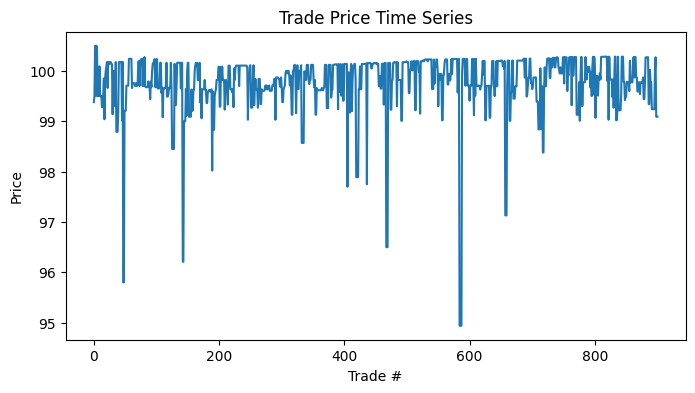

In [15]:
env = MarketEnvironment()

agents = [
    RandomTrader(1),
    MarketMaker(2),
    NoiseTrader(3),
    MarketTaker(4)
]

for _ in range(500):
    orders = []
    for agent in agents:
        orders.extend(agent.act(env))
    env.step(orders)

plot_trade_prices(env.trades)
